In [1]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">
  <td>
    <a href="https://github.com/GoogleCloudPlatform/analytics-componentized-patterns/blob/master/retail/clustering/bqml/bqml_scaled_clustering.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

# How to build k-means clustering models for market segmentation using BigQuery ML

A common marketing analytics challenge is to understand consumer behavior and develop customer attributes or archetypes.  As organizations get better at tackling this problem, they can activate marketing strategies to incorporate additional customer knowledge into their campaigns.  

Clustering algorithms are a common vehicle to address this challenge. They allow businesses to better segment and understand their customers and users.  In the field of Machine Learning, which is a combination of both art and science, unsupervised learning may require more art compared to supervised learning algorithms.  By definition, unsupervised learning has no single metric to guide the algorithm's learning process. Instead, the data science team will need to work hand in hand with business owners to determine feature selection, optimal number of clusters (the number of clusters is often abbreviated as k), and most importantly, to gain a deeper understanding of what each cluster represents.    

### How can clustering algorithms help businesses succeed?

Clustering algorithms can help companies identify groups of similar customers that can be used for targeting in advertising campaigns. This is paramount as we are breathing a prediction era where customers expect personalization from brands. 
 
Using a public sample Google Analytics 360 e-commerce dataset on BigQuery, you will learn how to create and deploy clustering algorithms in production. You will also get an example of how to navigate unsupervised learning.  Keep in mind, your clusters will be even more meaningful when you bring additional data.


# Objective

By the end of this notebook, you will know how to:
* Explore features to understand what might be interesting for a clustering model
* Pre-process data into the correct format needed to create a clustering model using BigQuery ML
* Train (and deploy) the k-means model in BigQuery ML
* Evaluate the model
* Make predictions using the model
* Write the results to be used for batch prediction, for example, to send ads based on segmentation

## Dataset

The [Google Analytics Sample](https://console.cloud.google.com/marketplace/details/obfuscated-ga360-data/obfuscated-ga360-data?filter=solution-type:dataset) dataset, which is hosted publicly on BigQuery, is a dataset that provides 12 months (August 2016 to August 2017) of obfuscated Google Analytics 360 data from the [Google Merchandise Store](https://www.googlemerchandisestore.com/), a real e-commerce store that sells Google-branded merchandise.


## Costs 

This tutorial uses billable components of Google Cloud Platform:

* BigQuery
* BigQuery ML

Learn about [BigQuery pricing](https://cloud.google.com/bigquery/pricing), [BigQuery ML
pricing](https://cloud.google.com/bigquery-ml/pricing) and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## PIP install packages and dependencies

In [ ]:
!pip install google-cloud-bigquery
!pip install google-cloud-bigquery-storage
!pip install pandas-gbq

# Reservation package needed to setup flex slots for flat-rate pricing
!pip install google-cloud-bigquery-reservation

In [ ]:
# Automatically restart kernel after installs
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

### Set up your Google Cloud Platform project

_The following steps are required, regardless of your notebook environment._

1. [Select or create a project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

1. [Enable the AI Platform APIs and Compute Engine APIs.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component)

1. Enter your project ID and region in the cell below. Then run the  cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

_Note_: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

### Set project ID and authenticate

Update your Project ID below.  The rest of the notebook will run using these credentials. 

In [ ]:
PROJECT_ID = "UPDATE TO YOUR PROJECT ID" 
REGION = 'US'
DATA_SET_ID = 'bqml_kmeans' # Ensure you first create a data set in BigQuery
!gcloud config set project $PROJECT_ID
# If you have not built the Data Set, the following command will build it for you
# !bq mk --location=$REGION --dataset $PROJECT_ID:$DATA_SET_ID 

### Import libraries and define constants

In [2]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
import pandas_gbq
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.3f' % x) # used to display float format
client = bigquery.Client(project=PROJECT_ID)

# Data exploration and preparation

Prior to building your models, you are typically expected to invest a significant amount of time cleaning, exploring, and aggregating your dataset in a meaningful way for modeling.  For the purpose of this demo, we aren't showing this step only to prioritize showcasing clustering with k-means in BigQuery ML.  

## Building synthetic data

Our goal is to use both online (GA360) and offline (CRM) data.  You can use your own CRM data, however, in this case since we don't have CRM data to showcase, we will instead generate synthetic data.  We will generate estimated House Hold Income, and Gender.  To do so, we will hash fullVisitorID and build simple rules based on the last digit of the hash. When you run this process with your own data, you can join CRM data with several dimensions, but this is just an example of what is possible.  

In [ ]:
# We start with GA360 data, and will eventually build synthetic CRM as an example.  
# This block is the first step, just working with GA360

ga360_only_view = 'GA360_View'
shared_dataset_ref = client.dataset(DATA_SET_ID)
ga360_view_ref = shared_dataset_ref.table(ga360_only_view)
ga360_view = bigquery.Table(ga360_view_ref)

ga360_query = '''
SELECT
  fullVisitorID,
  ABS(farm_fingerprint(fullVisitorID)) AS Hashed_fullVisitorID, # This will be used to generate random data.
  MAX(device.operatingSystem) AS OS, # We can aggregate this because an OS is tied to a fullVisitorID.
  SUM (CASE
       WHEN REGEXP_EXTRACT (v2ProductCategory, 
                           r'^(?:(?:.*?)Home/)(.*?)/') 
                           = 'Apparel' THEN 1 ELSE 0 END) AS Apparel,
  SUM (CASE  
       WHEN REGEXP_EXTRACT (v2ProductCategory, 
                           r'^(?:(?:.*?)Home/)(.*?)/') 
                           = 'Office' THEN 1 ELSE 0 END) AS Office,
  SUM (CASE
       WHEN REGEXP_EXTRACT (v2ProductCategory, 
                           r'^(?:(?:.*?)Home/)(.*?)/') 
                           = 'Electronics' THEN 1 ELSE 0 END) AS Electronics,
  SUM (CASE
       WHEN REGEXP_EXTRACT (v2ProductCategory, 
                           r'^(?:(?:.*?)Home/)(.*?)/') 
                           = 'Limited Supply' THEN 1 ELSE 0 END) AS LimitedSupply,
  SUM (CASE
       WHEN REGEXP_EXTRACT (v2ProductCategory, 
                           r'^(?:(?:.*?)Home/)(.*?)/') 
                           = 'Accessories' THEN 1 ELSE 0 END) AS Accessories,
  SUM (CASE
       WHEN REGEXP_EXTRACT (v2ProductCategory, 
                           r'^(?:(?:.*?)Home/)(.*?)/') 
                           = 'Shop by Brand' THEN 1 ELSE 0 END) AS ShopByBrand,
  SUM (CASE
       WHEN REGEXP_EXTRACT (v2ProductCategory, 
                           r'^(?:(?:.*?)Home/)(.*?)/') 
                           = 'Bags' THEN 1 ELSE 0 END) AS Bags,
  ROUND (SUM (productPrice/1000000),2) AS productPrice_USD
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
  UNNEST(hits) AS hits,
  UNNEST(hits.product) AS hits_product
WHERE
  _TABLE_SUFFIX BETWEEN '20160801'
  AND '20160831'
  AND geoNetwork.country = 'United States'
  AND type = 'EVENT'
GROUP BY
  1,
  2
'''


ga360_view.view_query = ga360_query.format(PROJECT_ID)
ga360_view = client.create_table(ga360_view)  # API request

print(f"Successfully created view at {ga360_view.full_table_id}")

In [4]:
# Show a sample of GA360 data

ga360_query_df = f'''
SELECT * FROM {ga360_view.full_table_id.replace(":", ".")} LIMIT 5
'''

job_config = bigquery.QueryJobConfig()

# Start the query
query_job = client.query(ga360_query_df, job_config=job_config) #API Request
df_ga360 = query_job.result()
df_ga360 = df_ga360.to_dataframe()

df_ga360

,fullVisitorID,Hashed_fullVisitorID,OS,Apparel,Office,Electronics,LimitedSupply,Accessories,ShopByBrand,Bags,productPrice_USD
0,0793220752145578759,4074807331962730552,Linux,4,0,0,0,0,0,0,148.960
1,6626084732166116798,9209336555480734198,Windows,1,0,0,0,0,0,0,28.990
2,6402635554390648387,6330846949202373940,Windows,102,0,0,0,0,0,0,2247.980
3,1774577907793414721,6826645565243937471,Chrome OS,7,0,0,1,0,0,0,289.910
4,9875610913644487984,8099941684224314656,iOS,0,0,0,0,1,0,0,24.990


In [ ]:
# Create synthetic CRM data in SQL

CRM_only_view = 'CRM_View'
shared_dataset_ref = client.dataset(DATA_SET_ID)
CRM_view_ref = shared_dataset_ref.table(CRM_only_view)
CRM_view = bigquery.Table(CRM_view_ref)

# Query below works by hashing the fullVisitorID, which creates a random distribution.  
# We use modulo to artificially split gender and hhi distribution.
CRM_query = '''
SELECT
  fullVisitorID,
IF
  (MOD(Hashed_fullVisitorID,2) = 0,
    "M",
    "F") AS gender,
  CASE
    WHEN MOD(Hashed_fullVisitorID,10) = 0 THEN 55000
    WHEN MOD(Hashed_fullVisitorID,10) < 3 THEN 65000
    WHEN MOD(Hashed_fullVisitorID,10) < 7 THEN 75000
    WHEN MOD(Hashed_fullVisitorID,10) < 9 THEN 85000
    WHEN MOD(Hashed_fullVisitorID,10) = 9 THEN 95000
  ELSE
  Hashed_fullVisitorID
END
  AS hhi
FROM (
  SELECT
    fullVisitorID,
    ABS(farm_fingerprint(fullVisitorID)) AS Hashed_fullVisitorID,
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits,
    UNNEST(hits.product) AS hits_product
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801'
    AND '20160831'
    AND geoNetwork.country = 'United States'
    AND type = 'EVENT'
  GROUP BY
    1,
    2)
'''

CRM_view.view_query = CRM_query.format(PROJECT_ID)
CRM_view = client.create_table(CRM_view)  # API request

print(f"Successfully created view at {CRM_view.full_table_id}")

In [6]:
# See an output of the synthetic CRM data

CRM_query_df = f'''
SELECT * FROM {CRM_view.full_table_id.replace(":", ".")} LIMIT 5
'''

job_config = bigquery.QueryJobConfig()

# Start the query
query_job = client.query(CRM_query_df, job_config=job_config) #API Request
df_CRM = query_job.result()
df_CRM = df_CRM.to_dataframe()

df_CRM

,fullVisitorID,gender,hhi
0,297008845417084558,F,85000
1,8780554431432234301,F,65000
2,3912300160509220549,M,85000
3,0183860411504195373,M,55000
4,5824687589795910572,M,75000


## Build a final view for to use as trainding data for clustering

You may decide to change the view below based on your specific dataset.  This is fine, and is exactly why we're creating a view.  All steps subsequent to this will reference this view.  If you change the SQL below, you won't need to modify other parts of the notebook. 

In [ ]:
# Build a final view, which joins GA360 data with CRM data

final_data_view = 'Final_View'
shared_dataset_ref = client.dataset(DATA_SET_ID)
final_view_ref = shared_dataset_ref.table(final_data_view)
final_view = bigquery.Table(final_view_ref)

final_data_query = f'''
SELECT
    g.*,
    c.* EXCEPT(fullVisitorId)
FROM {ga360_view.full_table_id.replace(":", ".")} g
JOIN {CRM_view.full_table_id.replace(":", ".")} c
ON g.fullVisitorId = c.fullVisitorId
'''

final_view.view_query = final_data_query.format(PROJECT_ID)
final_view = client.create_table(final_view)  # API request

print(f"Successfully created view at {final_view.full_table_id}")

In [8]:
# Show final data used prior to modeling

sql_demo = f'''
SELECT * FROM {final_view.full_table_id.replace(":", ".")} LIMIT 5
'''

job_config = bigquery.QueryJobConfig()

# Start the query
query_job = client.query(sql_demo, job_config=job_config) #API Request
df_demo = query_job.result()
df_demo = df_demo.to_dataframe()

df_demo

,fullVisitorID,Hashed_fullVisitorID,OS,Apparel,Office,Electronics,LimitedSupply,Accessories,ShopByBrand,Bags,productPrice_USD,gender,hhi
0,0314742824007569667,6946654416482415939,Android,6,0,0,0,0,0,0,106.940,F,95000
1,2242360300500476735,7127521692467899408,Macintosh,0,0,0,0,1,0,0,1.990,M,85000
2,6667898188086359119,928068574965520919,iOS,0,0,0,0,0,0,0,4.990,F,95000
3,4757349846427056292,4102516958220717880,Chrome OS,0,0,1,0,0,0,0,1.500,M,55000
4,7253626747991065846,2270834522148945194,Android,0,0,0,0,0,0,0,92.990,M,75000


# Create our initial model

In this section, we will build our initial k-means model.  We won't focus on optimal k or other hyperparemeters just yet.

Some additional points:  

1. We remove fullVisitorId as an input, even though it is grouped at that level because we don't need fullVisitorID as a feature for clustering. fullVisitorID should never be used as feature.
2. We have both categorical as well as numerical features
3. We do not have to normalize any numerical features, as BigQuery ML will automatically do this for us. 

## Build a function to build our model

We will build a simple python function to build our model, rather than doing everything in SQL.  This approach means we can asynchronously start several models and let BQ run in parallel.

In [ ]:
def makeModel (n_Clusters, Model_Name):
    sql =f'''
    CREATE OR REPLACE MODEL `{PROJECT_ID}.{DATA_SET_ID}.{Model_Name}` 
    OPTIONS(model_type='kmeans',
    kmeans_init_method = 'KMEANS++',
    num_clusters={n_Clusters}) AS

    SELECT * except(fullVisitorID, Hashed_fullVisitorID) FROM `{final_view.full_table_id.replace(":", ".")}`
    '''
    job_config = bigquery.QueryJobConfig()
    client.query(sql, job_config=job_config)  # Make an API request.

In [13]:
# Let's start with a simple test to ensure everything works. 
# After running makeModel(), allow a few minutes for training to complete.

model_test_name = "test"
makeModel(3, model_test_name)

In [ ]:
# After training is completed, you can either check in the UI, or you can interact with it using list_models(). 

for model in client.list_models(DATA_SET_ID):
    print(model)

# Work towards creating a better model

In this section, we want to determine the proper k value.  Determining the right value of k depends completely on the use case.  There are straight forward examples that will simply tell you how many clusters are needed.  Suppose you are pre-processing hand written digits - this tells us k should be 10. Or perhaps your business stakeholder only wants to deliver three different marketing campaigns and needs you to identify three clusters of customers, then setting k=3 might be meaningful. However, the use case is sometimes more open ended and you may want to explore different numbers of clusters to see how your datapoints group together with the minimal error within each cluster. To accomplish this process, we start by performing the 'Elbow Method', which simply charts loss vs k. Then, we'll also use the Davies-Bouldin score.
(https://en.wikipedia.org/wiki/Davies%E2%80%93Bouldin_index)

Below we are going to create several models to perform both the Elbow Method and get the Davies-Bouldin score.  You may change parameters like low_k and high_k. Our process will create models between these two values.  There is an additional parameter called model_prefix_name.  We recommend you leave this as its current value.  It is used to generate a naming convention for our models. 

In [15]:
# Define upper and lower bound for k, then build individual models for each. 
# After running this loop, look at the UI to see several model objects that exist. 

low_k = 3
high_k = 15
model_prefix_name = 'kmeans_clusters_'

lst = list(range (low_k, high_k+1)) #build list to iterate through k values

for k in lst:
    model_name = model_prefix_name + str(k)
    makeModel(k, model_name)
    print(f"Model started: {model_name}")

Model started: kmeans_clusters_3
Model started: kmeans_clusters_4
Model started: kmeans_clusters_5
Model started: kmeans_clusters_6
Model started: kmeans_clusters_7
Model started: kmeans_clusters_8
Model started: kmeans_clusters_9
Model started: kmeans_clusters_10
Model started: kmeans_clusters_11
Model started: kmeans_clusters_12
Model started: kmeans_clusters_13
Model started: kmeans_clusters_14
Model started: kmeans_clusters_15


## Select optimal k

In [ ]:
# list all current models
models = client.list_models(DATA_SET_ID)  # Make an API request.
print("Listing current models:")
for model in models:
    full_model_id = f"{model.dataset_id}.{model.model_id}"
    print(full_model_id)

bqml_kmeans.kmeans_clusters_10
bqml_kmeans.kmeans_clusters_11
bqml_kmeans.kmeans_clusters_12
bqml_kmeans.kmeans_clusters_13
bqml_kmeans.kmeans_clusters_14
bqml_kmeans.kmeans_clusters_15
bqml_kmeans.kmeans_clusters_3
bqml_kmeans.kmeans_clusters_4
bqml_kmeans.kmeans_clusters_5
bqml_kmeans.kmeans_clusters_6
bqml_kmeans.kmeans_clusters_7
bqml_kmeans.kmeans_clusters_8
bqml_kmeans.kmeans_clusters_9
bqml_kmeans.test


In [ ]:
# Remove our sample model from BigQuery, so we only have remaining models from our previous loop

model_id = DATA_SET_ID+"."+model_test_name
client.delete_model(model_id)  # Make an API request.
print(f"Deleted model '{model_id}'")

Deleted model 'bqml_kmeans.test'.


In [ ]:
# This will create a dataframe with each model name, the Davies Bouldin Index, and Loss.  
# It will be used for the elbow method and to help determine optimal K

df = pd.DataFrame(columns=['davies_bouldin_index', 'mean_squared_distance'])
models = client.list_models(DATA_SET_ID)  # Make an API request.
for model in models:
    full_model_id = f"{model.dataset_id}.{model.model_id}"
    sql =f'''
        SELECT 
            davies_bouldin_index,
            mean_squared_distance 
        FROM ML.EVALUATE(MODEL `{full_model_id}`)
    '''

    job_config = bigquery.QueryJobConfig()

    # Start the query, passing in the extra configuration.
    query_job = client.query(sql, job_config=job_config)  # Make an API request.
    df_temp = query_job.to_dataframe()  # Wait for the job to complete.
    df_temp['model_name'] = model.model_id
    df =  pd.concat([df, df_temp], axis=0)

The code below assumes we've used the naming convention originally created in this notebook, and the k value occurs after the 2nd underscore.  If you've changed the model_prefix_name variable, then this code might break. 

In [ ]:
# This will modify the dataframe above, produce a new field with 'n_clusters', and will sort for graphing

df['n_clusters'] = df['model_name'].str.split('_').map(lambda x: x[2])
df['n_clusters'] = df['n_clusters'].apply(pd.to_numeric)
df = df.sort_values(by='n_clusters', ascending=True)
df

,davies_bouldin_index,mean_squared_distance,model_name,n_clusters
0,2.146,8.920,kmeans_clusters_3,3
0,1.576,8.492,kmeans_clusters_4,4
0,1.446,7.611,kmeans_clusters_5,5
0,2.272,7.459,kmeans_clusters_6,6
0,1.532,6.994,kmeans_clusters_7,7
0,1.678,6.582,kmeans_clusters_8,8
0,1.557,6.012,kmeans_clusters_9,9
0,1.285,5.870,kmeans_clusters_10,10
0,1.388,5.665,kmeans_clusters_11,11
0,1.607,5.075,kmeans_clusters_12,12


<AxesSubplot:xlabel='n_clusters'>

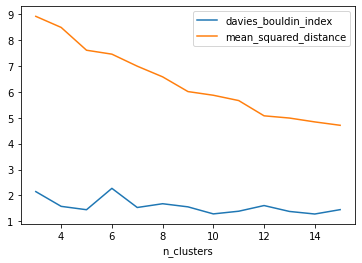

In [ ]:
df.plot.line(x='n_clusters', y=['davies_bouldin_index', 'mean_squared_distance'])

Note - when you run this notebook, you will get different results, due to random cluster initialization.  If you'd like to consistently return the same cluster for reach run, you may explicitly select your initialization through hyperparameter selection (https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create#kmeans_init_method). 

Making our k selection:  There is no perfect approach or process when determining the optimal k value. It can often be determined by business rules or requirements.  In this example, there isn't a simple requirement, so these considerations can also be followed:


1.   We start with the 'elbow method', which is effectively charting loss vs k.  Sometimes, though not always, there's a natural 'elbow' where incremental clusters do not drastically reduce loss.  In this specific example, and as you often might find, unfortunately there isn't a natural 'elbow', so we must continue our process. 
2.  Next, we chart Davies-Bouldin vs k.  This score tells us how 'different' each cluster is, with the optimal score at zero.  With 5 clusters, we see a score of ~1.4, and only with k>9, do we see better values. 
3. Finally, we begin to try to interpret the difference of each model. You can review the evaluation module for various models to understand distributions of our features.  With our data, we can look for patterns by gender, house hold income, and shopping habits.


# Analyze our final cluster

There are 2 options to understand the characteristics of your model.  You can either 1) look in the BigQuery UI, or you can 2) programmatically interact with your model object.  Below you’ll find a simple example for the latter option.  


In [72]:
model_to_use = 'kmeans_clusters_5' # User can edit this
final_model = DATA_SET_ID+'.'+model_to_use

sql_get_attributes = f'''
SELECT
  centroid_id,
  feature,
  categorical_value
FROM
  ML.CENTROIDS(MODEL {final_model})
WHERE
  feature IN ('OS','gender')
'''

job_config = bigquery.QueryJobConfig()

# Start the query
query_job = client.query(sql_get_attributes, job_config=job_config) #API Request
df_attributes = query_job.result()
df_attributes = df_attributes.to_dataframe()
df_attributes.head()

,centroid_id,feature,categorical_value
0,1,OS,"[{'category': 'Linux', 'value': 0.035714285714..."
1,1,gender,"[{'category': 'M', 'value': 0.4285714285714285..."
2,2,OS,"[{'category': 'iOS', 'value': 0.04276315789473..."
3,2,gender,"[{'category': 'F', 'value': 0.4967105263157895..."
4,3,OS,"[{'category': 'iOS', 'value': 0.09637391424238..."


In [60]:
# get numerical information about clusters

sql_get_numerical_attributes = f'''
WITH T AS (
SELECT 
  centroid_id,
  ARRAY_AGG(STRUCT(feature AS name, 
                   ROUND(numerical_value,1) AS value) 
                   ORDER BY centroid_id) 
                   AS cluster
FROM ML.CENTROIDS(MODEL {final_model})
GROUP BY centroid_id
),

Users AS(
SELECT
  centroid_id,
  COUNT(*) AS Total_Users
FROM(
SELECT
  * EXCEPT(nearest_centroids_distance)
FROM
  ML.PREDICT(MODEL {final_model},
    (
    SELECT
      *
    FROM
      {final_view.full_table_id.replace(":", ".")}
      )))
GROUP BY centroid_id
)

SELECT
  centroid_id,
  Total_Users,
  (SELECT value from unnest(cluster) WHERE name = 'Apparel') AS Apparel,
  (SELECT value from unnest(cluster) WHERE name = 'Office') AS Office,
  (SELECT value from unnest(cluster) WHERE name = 'Electronics') AS Electronics,
  (SELECT value from unnest(cluster) WHERE name = 'LimitedSupply') AS LimitedSupply,
  (SELECT value from unnest(cluster) WHERE name = 'Accessories') AS Accessories,
  (SELECT value from unnest(cluster) WHERE name = 'ShopByBrand') AS ShopByBrand,
  (SELECT value from unnest(cluster) WHERE name = 'Bags') AS Bags,
  (SELECT value from unnest(cluster) WHERE name = 'productPrice_USD') AS productPrice_USD,
  (SELECT value from unnest(cluster) WHERE name = 'hhi') AS hhi

FROM T LEFT JOIN Users USING(centroid_id)
ORDER BY centroid_id ASC
'''

job_config = bigquery.QueryJobConfig()

# Start the query
query_job = client.query(sql_get_numerical_attributes, job_config=job_config) #API Request
df_numerical_attributes = query_job.result()
df_numerical_attributes = df_numerical_attributes.to_dataframe()
df_numerical_attributes.head()

,centroid_id,Total_Users,Apparel,Office,Electronics,LimitedSupply,Accessories,ShopByBrand,Bags,Total_Purchases,productPrice_USD,hhi
0,1,31,90.800,11.200,9.300,4.000,5.900,1.600,1.300,158.900,3486.300,77857.100
1,2,344,14.600,5.100,5.700,2.400,0.800,3.000,3.100,44.700,1268.700,75296.100
2,3,7198,1.900,0.600,0.500,0.400,0.200,0.200,0.200,5.500,153.600,74898.000
3,4,301,4.100,2.500,1.600,1.600,7.300,0.400,0.000,22.300,383.700,75415.200
4,5,1,0.000,340.000,0.000,0.000,0.000,0.000,0.000,354.000,2022.900,75000.000


In addition to the output above, I'll note a few insights we get from our clusters. 

Cluster 1 - The apparel shopper, which also purchases more often than normal.  This (although synthetic data) segment skews female.

Cluster 2 - Most likely to shop by brand, and interested in bags. This segment has fewer purchases on average than the first cluster, however, this is the highest value customer.

Cluster 3 - The most populated cluster, this one has a small amount of purchases and spends less on average.  This segment is the one time buyer, rather than the brand loyalist.  

Cluster 4 - Most interested in accessories, does not buy as often as cluster 1 and 2, however buys more than cluster 3.  

Cluster 5 - This is an outlier as only 1 person belongs to this group.  

# Use model to group new website behavior, and then push results to GA360 for marketing activation

After we have a finalized model, we want to use it for inference.  The code below outlines how to score or assign users into clusters.  These are labeled as the CENTROID_ID.  Although this by itself is helpful, we also recommend a process to ingest these scores back into GA360. The easiest way to export your BigQuery ML predictions from a BigQuery table to Google Analytics 360 is to use the MoDeM (Model Deployment for Marketing, https://github.com/google/modem) reference implementation. MoDeM helps you load data into Google Analytics for eventual activation in Google Ads, Display & Video 360 and Search Ads 360.

In [17]:
sql_score = f'''
SELECT * EXCEPT(nearest_centroids_distance)
FROM
  ML.PREDICT(MODEL {final_model},
    (
    SELECT
      *
    FROM
      {final_view.full_table_id.replace(":", ".")}
      LIMIT 1))
'''

job_config = bigquery.QueryJobConfig()

# Start the query
query_job = client.query(sql_score, job_config=job_config) #API Request
df_score = query_job.result()
df_score = df_score.to_dataframe()

df_score

,CENTROID_ID,fullVisitorID,Hashed_fullVisitorID,OS,Apparel,Office,Electronics,LimitedSupply,Accessories,ShopByBrand,Bags,productPrice_USD,gender,hhi
0,5,3355435945434430291,2759439800079197041,Macintosh,0,0,0,6,0,0,5,1079.880,F,65000


# Clean up: Delete all models and tables 

In [12]:
# Are you sure you want to do this? This is to delete all models

models = client.list_models(DATA_SET_ID) # Make an API request.
for model in models:
    full_model_id = f"{model.dataset_id}.{model.model_id}"
    client.delete_model(full_model_id)  # Make an API request.
    print(f"Deleted: {full_model_id}")

Deleted: bqml_kmeans.kmeans_clusters_10
Deleted: bqml_kmeans.kmeans_clusters_11
Deleted: bqml_kmeans.kmeans_clusters_12
Deleted: bqml_kmeans.kmeans_clusters_13
Deleted: bqml_kmeans.kmeans_clusters_14
Deleted: bqml_kmeans.kmeans_clusters_15
Deleted: bqml_kmeans.kmeans_clusters_3
Deleted: bqml_kmeans.kmeans_clusters_4
Deleted: bqml_kmeans.kmeans_clusters_5
Deleted: bqml_kmeans.kmeans_clusters_6
Deleted: bqml_kmeans.kmeans_clusters_7
Deleted: bqml_kmeans.kmeans_clusters_8
Deleted: bqml_kmeans.kmeans_clusters_9
Deleted: bqml_kmeans.test


In [10]:
# Are you sure you want to do this? This is to delete all tables and views

tables = client.list_tables(DATA_SET_ID)  # Make an API request.
for table in tables:
    full_table_id = f"{table.dataset_id}.{table.table_id}"
    client.delete_table(full_table_id)  # Make an API request.
    print(f"Deleted: {full_table_id}")

Deleted: bqml_kmeans.CRM_View
Deleted: bqml_kmeans.Final_View
Deleted: bqml_kmeans.GA360_View


# Wrapping it all up

In this exercise, we’ve accomplished some cool things with k-means in BigQuery ML.  Most notably, we’re able to join online and offline user level information to gain more insight into a holistic view of our customers.  We’ve modeled user behavior, and detailed an approach to determine the optimal number of clusters.  We’re able to take this insight and apply to future behavior through inference.  Finally, we can import this inference score back into GA360 for future marketing campaigns. 